### Połączenie

In [2]:
from pyspark.sql import SparkSession, Row
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.pandas as ps

try:
    # Tworzenie sesji Spark
    spark = SparkSession.builder \
        .appName("PySpark SQL Server Connection") \
        .config("spark.jars", "mssql-jdbc-12.6.1.jre8.jar") \
        .getOrCreate()

    # Parametry połączenia z bazą danych MSSQL
    server_name = "mssql-server"
    port = "1433"
    database_name = "BAZUNIA1"
    url = f"jdbc:sqlserver://{server_name}:{port};databaseName={database_name}"

    table_name = "BAZUNIA1"
    username = "sa"
    password = "YourStrongPassword123"

    # Wczytanie danych z bazy danych MSSQL
    df = spark.read \
        .format("jdbc") \
        .option("url", url) \
        .option("dbtable", table_name) \
        .option("user", username) \
        .option("password", password) \
        .option("encrypt", "false") \
        .option("driver", "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
        .load()

    print("Dane zostały pomyślnie wczytane z MSSQL.")
    # Wyświetlenie pierwszych kilku wierszy DataFrame
 

except Exception as e:
    print("Wystąpił błąd podczas łączenia z bazą danych:", str(e))



Dane zostały pomyślnie wczytane z MSSQL.


## Tworzenie procesów ETL

### 1. Zaokrąglenie godzin do całości

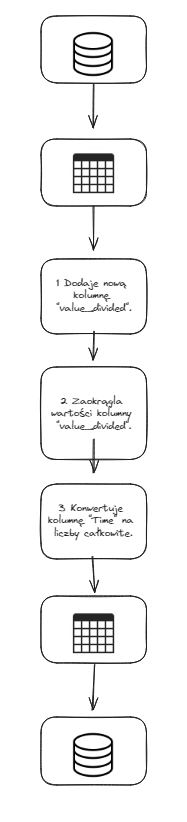

In [3]:
from IPython.display import Image
Image(filename='e1.png')

Pokazanie jak kolumna wygląda przed procesem

In [4]:
df.select("Time OCC").show(10)

+--------+
|Time OCC|
+--------+
|    2230|
|     720|
|     810|
|    1930|
|    2030|
|    1000|
|    1230|
|    1400|
|     440|
|    1034|
+--------+
only showing top 10 rows



Najłatwiej będzie podzielić liczby przez 100, wyciągnąć całości oraz zamienić na zmienną typu integer

In [5]:
df = df.withColumn("value_divided", col("Time OCC") / 100) # 1 Dodaje nową kolumnę "value_divided".
df = df.withColumn("Time", round(col("value_divided"), 0)) # 2 Zaokrągla wartości kolumny "value_divided".
df = df.withColumn("Time", col("Time").cast("integer")) # 3  Konwertuje kolumnę "Time" na liczby całkowite.

Pokazanie jak dane wyglądają po procesie

In [6]:
df.select('Time').show(10)

+----+
|Time|
+----+
|  22|
|   7|
|   8|
|  19|
|  20|
|  10|
|  12|
|  14|
|   4|
|  10|
+----+
only showing top 10 rows



### 2. Wyciągnięcie dat przestępstwa

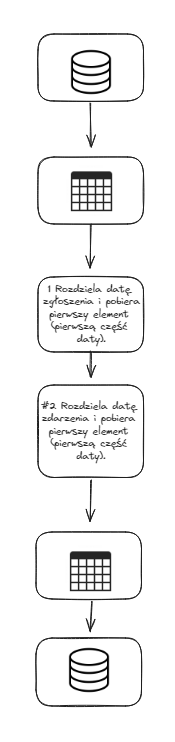

In [7]:
from IPython.display import Image
Image(filename='2ETL.png')

Pokazanie jak kolumna wygląda przed procesem

In [8]:
df.select('Date Rptd').show(10)

+--------------------+
|           Date Rptd|
+--------------------+
|01/08/2020 12:00:...|
|01/29/2020 12:00:...|
|01/27/2020 12:00:...|
|04/09/2020 12:00:...|
|01/20/2020 12:00:...|
|01/29/2020 12:00:...|
|03/23/2020 12:00:...|
|07/20/2020 12:00:...|
|06/28/2020 12:00:...|
|04/18/2020 12:00:...|
+--------------------+
only showing top 10 rows



Pozbycie się godzin z daty, prawdopodobnie są to godziny pisania raportów

In [9]:
from pyspark.sql.functions import split, col

df = df.withColumn("Date Rptd", split(col("Date Rptd"), " ").getItem(0)) # 1 Rozdziela datę zgłoszenia i pobiera pierwszy element (pierwszą część daty).
df = df.withColumn("DATE OCC", split(col("DATE OCC"), " ").getItem(0)) #2 Rozdziela datę zdarzenia i pobiera pierwszy element (pierwszą część daty).

Pokazanie jak dane wyglądają po procesie

In [10]:
df.select('Date Rptd').show(10)

+----------+
| Date Rptd|
+----------+
|01/08/2020|
|01/29/2020|
|01/27/2020|
|04/09/2020|
|01/20/2020|
|01/29/2020|
|03/23/2020|
|07/20/2020|
|06/28/2020|
|04/18/2020|
+----------+
only showing top 10 rows



Na podstawie daty stworzenie kolumny dzień, miesiąc, kwartał, rok.

In [11]:
from pyspark.sql.functions import split, col

# Split the DATE OCC column into month, day, and year
df = df.withColumn("Month", split(col("DATE OCC"), "/").getItem(0)) \
             .withColumn("Day", split(col("DATE OCC"), "/").getItem(1)) \
             .withColumn("Year", split(col("DATE OCC"), "/").getItem(2))

df.select("Day", "Month", "Year").show()


+---+-----+----+
|Day|Month|Year|
+---+-----+----+
| 08|   01|2020|
| 29|   01|2020|
| 27|   01|2020|
| 31|   03|2020|
| 19|   01|2020|
| 29|   01|2020|
| 23|   03|2020|
| 06|   07|2020|
| 27|   06|2020|
| 13|   04|2020|
| 09|   05|2020|
| 25|   05|2020|
| 15|   06|2020|
| 12|   06|2020|
| 24|   06|2020|
| 13|   03|2020|
| 22|   03|2020|
| 22|   05|2020|
| 17|   02|2020|
| 28|   03|2020|
+---+-----+----+
only showing top 20 rows



In [12]:
from pyspark.sql.functions import when

# Utwórz kolumnę 'Quarter' na podstawie kolumny 'Month'
df = df.withColumn("Quarter",
                   when(df["Month"].between(1, 3), 1)
                   .when(df["Month"].between(4, 6), 2)
                   .when(df["Month"].between(7, 9), 3)
                   .otherwise(4))

df.select("Day", "Month","Quarter", "Year").show()

+---+-----+-------+----+
|Day|Month|Quarter|Year|
+---+-----+-------+----+
| 08|   01|      1|2020|
| 29|   01|      1|2020|
| 27|   01|      1|2020|
| 31|   03|      1|2020|
| 19|   01|      1|2020|
| 29|   01|      1|2020|
| 23|   03|      1|2020|
| 06|   07|      3|2020|
| 27|   06|      2|2020|
| 13|   04|      2|2020|
| 09|   05|      2|2020|
| 25|   05|      2|2020|
| 15|   06|      2|2020|
| 12|   06|      2|2020|
| 24|   06|      2|2020|
| 13|   03|      1|2020|
| 22|   03|      1|2020|
| 22|   05|      2|2020|
| 17|   02|      1|2020|
| 28|   03|      1|2020|
+---+-----+-------+----+
only showing top 20 rows



### 3. Stworzenie kolumny z dniem tygodnia w jakim miało miejsce przestępstwo na podstawie daty

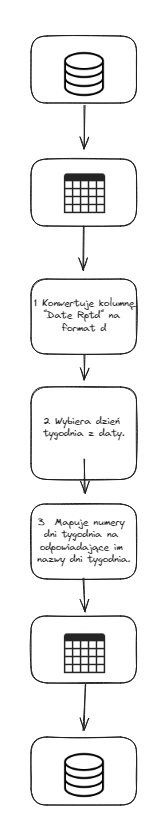

In [13]:
from IPython.display import Image
Image(filename='3ETL.png')


Pokazanie jak kolumna wygląda przed procesem

In [14]:
df.select('Date Rptd').show(10)

+----------+
| Date Rptd|
+----------+
|01/08/2020|
|01/29/2020|
|01/27/2020|
|04/09/2020|
|01/20/2020|
|01/29/2020|
|03/23/2020|
|07/20/2020|
|06/28/2020|
|04/18/2020|
+----------+
only showing top 10 rows



Kod to procesu: sposób numer jeden

In [15]:
df = df.withColumn("Date Rptd", to_date(df["Date Rptd"], "MM/dd/yyyy")) # 1 Konwertuje kolumnę "Date Rptd" na format daty.

# Wybierz dzień tygodnia z daty
df= df.withColumn("Day of Week", dayofweek(df["Date Rptd"])) # 2 Wybiera dzień tygodnia z daty.


df = df.withColumn("Day of Week", 
                   when(df["Day of Week"] == lit(1), lit("Sunday"))
                   .when(df["Day of Week"] == lit(2), lit("Monday"))
                   .when(df["Day of Week"] == lit(3), lit("Tuesday"))
                   .when(df["Day of Week"] == lit(4), lit("Wednesday"))
                   .when(df["Day of Week"] == lit(5), lit("Thursday"))
                   .when(df["Day of Week"] == lit(6), lit("Friday"))
                   .when(df["Day of Week"] == lit(7), lit("Saturday"))
                   .otherwise(None)) # 3  Mapuje numery dni tygodnia na odpowiadające im nazwy dni tygodnia.




Kod to procesu: sposób numer dwa

In [16]:
from pyspark.sql.functions import dayofweek, to_date
df_with_day_of_week = df.withColumn("Date Rptd", dayofweek(df["Date Rptd"]))
df_with_day_of_week.select('Day of Week').show(3)

+-----------+
|Day of Week|
+-----------+
|  Wednesday|
|  Wednesday|
|     Monday|
+-----------+
only showing top 3 rows



Pokazanie jak dane wyglądają po procesie

In [17]:
# Wyświetl DataFrame z nową kolumną 'Day of Week'
df.select('Day of Week').show(10)

+-----------+
|Day of Week|
+-----------+
|  Wednesday|
|  Wednesday|
|     Monday|
|   Thursday|
|     Monday|
|  Wednesday|
|     Monday|
|     Monday|
|     Sunday|
|   Saturday|
+-----------+
only showing top 10 rows



### 4. W kolumnie 'Vict Sex' zamiana wartości: F, M, X, Null na wartości Female, Male, X-gender oraz no data

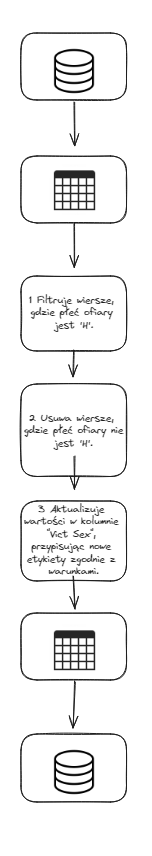

In [18]:
from IPython.display import Image
Image(filename='4ETL.png')

Pokazanie jak kolumna wygląda przed procesem

In [19]:

df.select('Vict Sex').show(5)

+--------+
|Vict Sex|
+--------+
|       F|
|       M|
|       F|
|       F|
|       F|
+--------+
only showing top 5 rows



Kod procesu ETL zmieniającego na wartości, które chcemy mieć w kolumnie

In [20]:
count_H = df.filter(df['Vict Sex'].isNotNull()).count()
print(count_H)
count_H = df.filter(df['Vict Sex'] == 'H').count()
print(count_H)

1334
0


In [21]:
outed_data = (df.filter((df['Vict Sex'] == 'H'))) # 1 Filtruje wiersze, gdzie płeć ofiary jest 'H'.
df = df.filter((df['Vict Sex'] != 'H')) # 2 Usuwa wiersze, gdzie płeć ofiary nie jest 'H'.

# Aktualizacja wartości w kolumnie 'Vict Sex'
df = df.withColumn("Vict Sex", 
                   when(df["Vict Sex"] == "F", "Female")
                   .when(df["Vict Sex"] == "M", "Male")
                   .when(df["Vict Sex"] == "X", "X-gender")
                   .when(df["Vict Sex"].isNull(), "no data")
                   .otherwise(df["Vict Sex"])) # 3 Aktualizuje wartości w kolumnie "Vict Sex", 
#przypisując nowe etykiety zgodnie z warunkami.




Pokazanie jak kolumna wygląda po procesem

In [22]:
df.select('Vict Sex').show(5)

+--------+
|Vict Sex|
+--------+
|  Female|
|    Male|
|  Female|
|  Female|
|  Female|
+--------+
only showing top 5 rows



### 5. Wybranie top 5 najczęściej występujących ras z kolumny Vict Descent zamiana ich na odpowiadające im nazwy oraz zamiana pozostałych na słowo 'other'

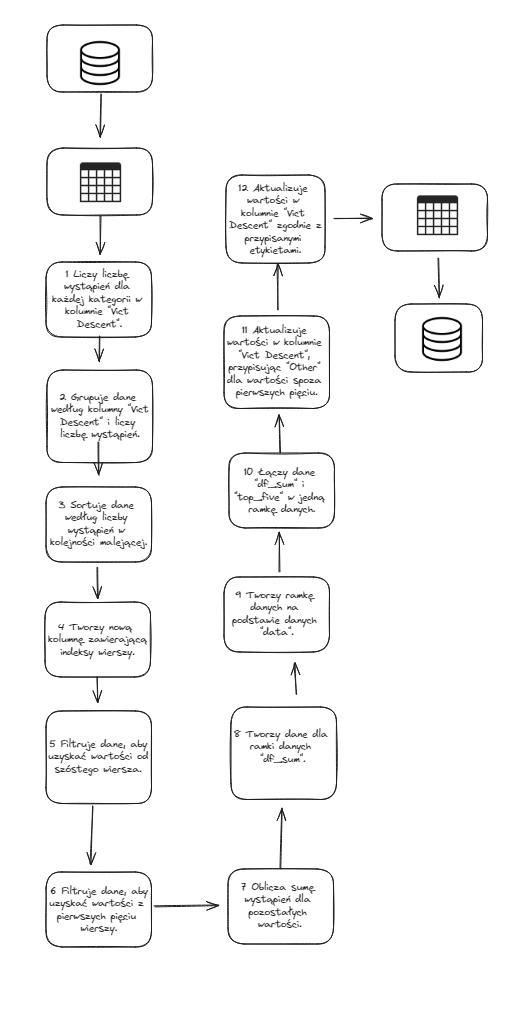

In [23]:
from IPython.display import Image
Image(filename='5ETL.png')

Pokazanie jak kolumna wygląda przed procesem

In [24]:
df.select('Vict Descent').distinct().show()

+------------+
|Vict Descent|
+------------+
|           K|
|           F|
|           B|
|           O|
|           C|
|           J|
|           A|
|           X|
|           W|
|           H|
+------------+



Czynności zamieniające te dane

In [25]:
counts_df = df.groupBy("Vict Descent").count() # 1 Liczy liczbę wystąpień dla każdej kategorii w kolumnie "Vict Descent".
counts_df.show()

+------------+-----+
|Vict Descent|count|
+------------+-----+
|           K|   12|
|           F|    8|
|           B|  176|
|           O|  108|
|           C|    6|
|           J|    2|
|           A|   46|
|           X|  148|
|           W|  348|
|           H|  480|
+------------+-----+



In [26]:
df_gb = df.groupBy("Vict Descent").count() # 2 Grupuje dane według kolumny "Vict Descent" i liczy liczbę wystąpień.

df_gb = df_gb.orderBy('count', ascending=False) # 3 Sortuje dane według liczby wystąpień w kolejności malejącej.

start_row = 6

df_gb = df_gb.withColumn("row_index", monotonically_increasing_id()) # 4 Tworzy nową kolumnę zawierającą indeksy wierszy.

# Przypisanie elementów od 6. wiersza
others = df_gb.filter(df_gb["row_index"] >= start_row) # 5 Filtruje dane, aby uzyskać wartości od szóstego wiersza.

top_five = df_gb.filter(df_gb['row_index'] < start_row) # 6 Filtruje dane, aby uzyskać wartości z pierwszych pięciu wierszy.

In [27]:
top_five.show()

+------------+-----+---------+
|Vict Descent|count|row_index|
+------------+-----+---------+
|           H|  480|        0|
|           W|  348|        1|
|           B|  176|        2|
|           X|  148|        3|
|           O|  108|        4|
|           A|   46|        5|
+------------+-----+---------+



In [28]:
suma = others.agg(sum("count")).collect()[0][0] # 7 Oblicza sumę wystąpień dla pozostałych wartości.


data = [('Other', suma, 6)] # 8 Tworzy dane dla ramki danych "df_sum".

# Tworzenie ramki danych
df_sum = spark.createDataFrame(data, ["Vict Descent", "count", 'row_index']) # 9 Tworzy ramkę danych na podstawie danych "data".

df_sum.show()

+------------+-----+---------+
|Vict Descent|count|row_index|
+------------+-----+---------+
|       Other|   28|        6|
+------------+-----+---------+



In [29]:
combined_df = df_sum.union(top_five) # 10 Łączy dane "df_sum" i "top_five" w jedną ramkę danych.
combined_df.show()

+------------+-----+---------+
|Vict Descent|count|row_index|
+------------+-----+---------+
|       Other|   28|        6|
|           H|  480|        0|
|           W|  348|        1|
|           B|  176|        2|
|           X|  148|        3|
|           O|  108|        4|
|           A|   46|        5|
+------------+-----+---------+



In [30]:
top_five = top_five.filter(top_five["Vict Descent"] != 'O')
top_five.show()

+------------+-----+---------+
|Vict Descent|count|row_index|
+------------+-----+---------+
|           H|  480|        0|
|           W|  348|        1|
|           B|  176|        2|
|           X|  148|        3|
|           A|   46|        5|
+------------+-----+---------+



In [31]:
tfv = top_five.select('Vict Descent')
tfv.show()

+------------+
|Vict Descent|
+------------+
|           H|
|           W|
|           B|
|           X|
|           A|
+------------+



In [32]:
from pyspark.sql.functions import when

# Utworzenie warunku
top_five_values = top_five.select('Vict Descent').distinct().collect()
top_five_values = [row['Vict Descent'] for row in top_five_values]
condition = ~df['Vict Descent'].isin(top_five_values)

# Tworzenie nowej kolumny na podstawie warunku
df = df.withColumn('Vict Descent', when(condition, 'Other').otherwise(df['Vict Descent']))
# 11 Aktualizuje wartości w kolumnie "Vict Descent", przypisując "Other" dla wartości spoza pierwszych pięciu.
print(top_five_values)

['H', 'W', 'B', 'X', 'A']


In [33]:
df = df.withColumn("Vict Descent", 
                   when(df["Vict Descent"] == "H", "Hispanic or Latino")
                   .when(df["Vict Descent"] == "W", "White")
                   .when(df["Vict Descent"] == "B", "Black")
                   .when(df["Vict Descent"] == "X", "Unknown")
                   .when(df["Vict Descent"] == "O", "Other")
                   .when(df["Vict Descent"] == "A", "Asian")
                   .otherwise(df["Vict Descent"])) # 12 Aktualizuje wartości w kolumnie "Vict Descent" zgodnie z przypisanymi etykietami.

Pokazanie jak kolumna wygląda po procesem

In [34]:
df.select("Vict Descent").show(10)

+------------------+
|      Vict Descent|
+------------------+
|             Black|
|Hispanic or Latino|
|Hispanic or Latino|
|             Other|
|Hispanic or Latino|
|Hispanic or Latino|
|Hispanic or Latino|
|             White|
|             Black|
|             White|
+------------------+
only showing top 10 rows



### 6. Zamiana kraju pochodzenia z kolumny country of criminal na całą nazwę zamiast litery i wybranie top 5 zamiana zsumowanie pozostałych i dodanie do siebie i nazwanie jako inne

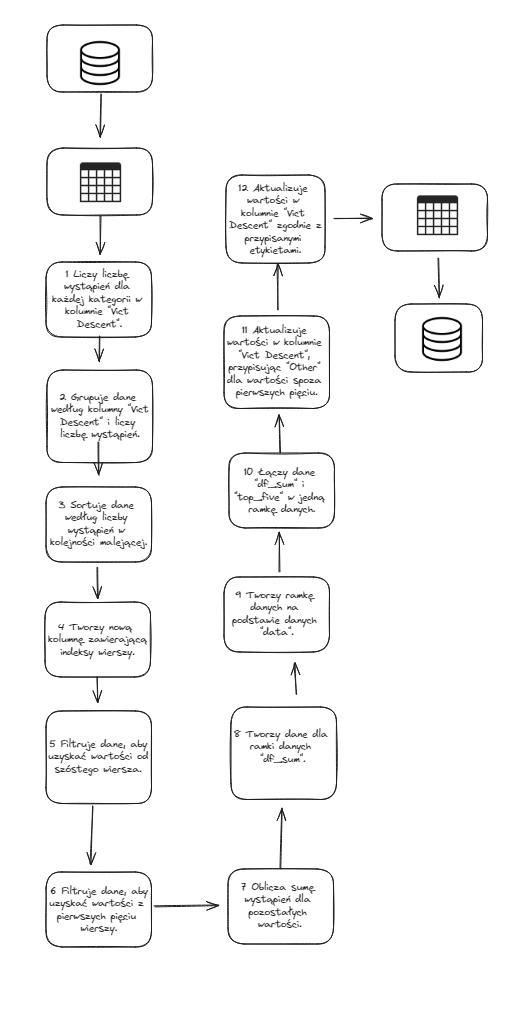

In [35]:
from IPython.display import Image
Image(filename='5ETL.png')

Pokazanie jak kolumna wygląda po procesem

In [36]:
df.select('country of criminal').distinct().show()

+-------------------+
|country of criminal|
+-------------------+
|                  K|
|                  F|
|                  B|
|                  L|
|                  U|
|                  V|
|                  O|
|                  D|
|                  C|
|                  J|
|                  Z|
|                  A|
|                  X|
|                  W|
|                  S|
|                  G|
|                  I|
|                  P|
|                  H|
|               NULL|
+-------------------+



Kroki ETLa

In [37]:
df = df.withColumn("country of criminal", 
                   when(df["country of criminal"] == "H", "Hispanic or Latino")
                   .when(df["country of criminal"] == "W", "White")
                   .when(df["country of criminal"] == "B", "Black")
                   .when(df["country of criminal"] == "X", "Unknown")
                   .when(df["country of criminal"] == "O", "Other")
                   .when(df["country of criminal"] == "A", "Asian")
                   .otherwise(df["country of criminal"]))

In [38]:
df = df.withColumn("country of criminal", 
                   when((length("country of criminal") == 1) | (col("country of criminal").isNull()), "Other")
                   .otherwise(col("country of criminal")))

Pokazanie jak kolumna wygląda po procesem

In [39]:
df.select("country of criminal").show()

+-------------------+
|country of criminal|
+-------------------+
|              Other|
|              Black|
|              Black|
| Hispanic or Latino|
|              Other|
|              Black|
|            Unknown|
|              Other|
|              Asian|
|              Black|
|              Other|
| Hispanic or Latino|
|              Other|
|              Other|
|              White|
|              Other|
|              White|
|              Black|
| Hispanic or Latino|
|            Unknown|
+-------------------+
only showing top 20 rows



### 7. Zamiana wartości wieku w kolumnie **Vict Age** na przedziały wiekowe

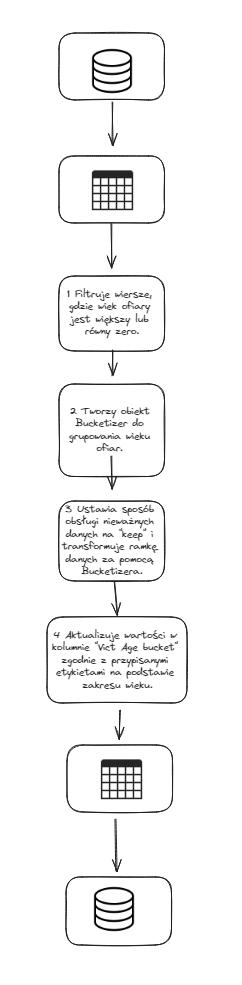

In [40]:
from IPython.display import Image
Image(filename='7ETL.png')

Pokazanie jak kolumna wygląda przed procesem

In [41]:
df.select('Vict Age').distinct().show(10)

+--------+
|Vict Age|
+--------+
|      29|
|      26|
|      65|
|      54|
|      19|
|       0|
|      22|
|      77|
|      34|
|      50|
+--------+
only showing top 10 rows



Kod procesu

In [42]:
from pyspark.ml.feature import Bucketizer
 # 1 Filtruje wiersze, gdzie wiek ofiary jest większy lub równy zero.
df = df.filter(df['Vict Age'] >= 0)
# 2 Tworzy obiekt Bucketizer do grupowania wieku ofiar. 
bucketizer = Bucketizer(splits=[0, 18, 35, 60,120, float('Inf') ],
                        inputCol="Vict Age", outputCol="Vict Age bucket")
# 3 Ustawia sposób obsługi nieważnych danych na "keep" i transformuje ramkę danych za pomocą Bucketizera.
df = bucketizer.setHandleInvalid("keep").transform(df)

# 4 Aktualizuje wartości w kolumnie "Vict Age bucket" zgodnie z przypisanymi etykietami na podstawie zakresu wieku.
df = df.withColumn("Vict Age bucket", 
                   when(df["Vict Age bucket"] == 0.0, "0-18")
                   .when(df["Vict Age bucket"] == 1.0, "18-35")
                   .when(df["Vict Age bucket"] == 2.0, "35-60")
                   .when(df["Vict Age bucket"] == 3.0, "60-100")
                   .otherwise("Unknown"))



Pokazanie jak kolumna wygląda przed procesem

In [43]:
df.select('Vict Age bucket').show()

+---------------+
|Vict Age bucket|
+---------------+
|          35-60|
|          35-60|
|          35-60|
|          35-60|
|           0-18|
|          35-60|
|          35-60|
|          35-60|
|          35-60|
|         60-100|
|          18-35|
|         60-100|
|          18-35|
|           0-18|
|          35-60|
|           0-18|
|          35-60|
|           0-18|
|         60-100|
|         60-100|
+---------------+
only showing top 20 rows



## Zapis do bazy danych po wykonaniu procesów ETL (nadpisanie)

In [44]:
server_name = "mssql-server"
port = "1433"
database_name = "ETLKI"
url = f"jdbc:sqlserver://{server_name}:{port};databaseName={database_name}"

table_name = "ETLKI"
username = "sa"
password = "YourStrongPassword123"

df.write \
    .format("jdbc") \
    .option("url", url) \
    .option("dbtable", table_name) \
    .option("user", username) \
    .option("password", password) \
    .option("encrypt", "false") \
    .option("driver", "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
    .mode("overwrite") \
    .save()
print('przeszło')

przeszło


In [45]:
spark.stop()